In [ ]:
import numpy as np
import theano
import theano.tensor as T
import lasagne
import matplotlib.pyplot as plt
import scipy as sp
import itertools
import pickle

from os import listdir
from os.path import join, isfile
from tqdm import tqdm

%matplotlib inline

WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release (v0.10).  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

Using gpu device 3: Tesla M2075 (CNMeM is enabled with initial size: 80.0% of memory, cuDNN not available)


In [ ]:
from collections import OrderedDict
from lasagne.init import HeNormal
from lasagne.layers import InputLayer, ConcatLayer, Pool2DLayer, ReshapeLayer, DimshuffleLayer, \
NonlinearityLayer, DropoutLayer, Deconv2DLayer, batch_norm, Conv2DLayer as ConvLayer

try:
    from lasagne.layers.dnn import Conv2DDNNLayer as ConvLayer
except ImportError:
    from lasagne.layers import Conv2DLayer as ConvLayer


def build_UNet( input_dim=(3, 128, 128), num_output_classes=2, pad='same', nonlinearity=lasagne.nonlinearities.elu, base_n_filters=64, do_dropout=False):
    net = OrderedDict()
    net['input'] = InputLayer((None,) + input_dim)

    net['contr_1_1'] = batch_norm(ConvLayer(net['input'], base_n_filters, 3, nonlinearity=nonlinearity, pad=pad, W=HeNormal(gain="relu")))
    net['contr_1_2'] = batch_norm(ConvLayer(net['contr_1_1'], base_n_filters, 3, nonlinearity=nonlinearity, pad=pad, W=HeNormal(gain="relu")))
    net['pool1'] = Pool2DLayer(net['contr_1_2'], 2)

    net['contr_2_1'] = batch_norm(ConvLayer(net['pool1'], base_n_filters*2, 3, nonlinearity=nonlinearity, pad=pad, W=HeNormal(gain="relu")))
    net['contr_2_2'] = batch_norm(ConvLayer(net['contr_2_1'], base_n_filters*2, 3, nonlinearity=nonlinearity, pad=pad, W=HeNormal(gain="relu")))
    net['pool2'] = Pool2DLayer(net['contr_2_2'], 2)

    net['contr_3_1'] = batch_norm(ConvLayer(net['pool2'], base_n_filters*4, 3, nonlinearity=nonlinearity, pad=pad, W=HeNormal(gain="relu")))
    net['contr_3_2'] = batch_norm(ConvLayer(net['contr_3_1'], base_n_filters*4, 3, nonlinearity=nonlinearity, pad=pad, W=HeNormal(gain="relu")))
    net['pool3'] = Pool2DLayer(net['contr_3_2'], 2)

    net['contr_4_1'] = batch_norm(ConvLayer(net['pool3'], base_n_filters*8, 3, nonlinearity=nonlinearity, pad=pad, W=HeNormal(gain="relu")))
    net['contr_4_2'] = batch_norm(ConvLayer(net['contr_4_1'], base_n_filters*8, 3, nonlinearity=nonlinearity, pad=pad, W=HeNormal(gain="relu")))
    l = net['pool4'] = Pool2DLayer(net['contr_4_2'], 2)

    if do_dropout:
        l = DropoutLayer(l, p=0.4)

    net['encode_1'] = batch_norm(ConvLayer(l, base_n_filters*16, 3, nonlinearity=nonlinearity, pad=pad, W=HeNormal(gain="relu")))
    net['encode_2'] = batch_norm(ConvLayer(net['encode_1'], base_n_filters*16, 3, nonlinearity=nonlinearity, pad=pad, W=HeNormal(gain="relu")))
    net['upscale1'] = batch_norm(Deconv2DLayer(net['encode_2'], base_n_filters*16, 2, 2, crop="valid", nonlinearity=nonlinearity, W=HeNormal(gain="relu")))

    net['concat1'] = ConcatLayer([net['upscale1'], net['contr_4_2']], cropping=(None, None, "center", "center"))
    net['expand_1_1'] = batch_norm(ConvLayer(net['concat1'], base_n_filters*8, 3, nonlinearity=nonlinearity, pad=pad, W=HeNormal(gain="relu")))
    net['expand_1_2'] = batch_norm(ConvLayer(net['expand_1_1'], base_n_filters*8, 3, nonlinearity=nonlinearity, pad=pad, W=HeNormal(gain="relu")))
    net['upscale2'] = batch_norm(Deconv2DLayer(net['expand_1_2'], base_n_filters*8, 2, 2, crop="valid", nonlinearity=nonlinearity, W=HeNormal(gain="relu")))

    net['concat2'] = ConcatLayer([net['upscale2'], net['contr_3_2']], cropping=(None, None, "center", "center"))
    net['expand_2_1'] = batch_norm(ConvLayer(net['concat2'], base_n_filters*4, 3, nonlinearity=nonlinearity, pad=pad, W=HeNormal(gain="relu")))
    net['expand_2_2'] = batch_norm(ConvLayer(net['expand_2_1'], base_n_filters*4, 3, nonlinearity=nonlinearity, pad=pad, W=HeNormal(gain="relu")))
    net['upscale3'] = batch_norm(Deconv2DLayer(net['expand_2_2'], base_n_filters*4, 2, 2, crop="valid", nonlinearity=nonlinearity, W=HeNormal(gain="relu")))

    net['concat3'] = ConcatLayer([net['upscale3'], net['contr_2_2']], cropping=(None, None, "center", "center"))
    net['expand_3_1'] = batch_norm(ConvLayer(net['concat3'], base_n_filters*2, 3, nonlinearity=nonlinearity, pad=pad, W=HeNormal(gain="relu")))
    net['expand_3_2'] = batch_norm(ConvLayer(net['expand_3_1'], base_n_filters*2, 3, nonlinearity=nonlinearity, pad=pad, W=HeNormal(gain="relu")))
    net['upscale4'] = batch_norm(Deconv2DLayer(net['expand_3_2'], base_n_filters*2, 2, 2, crop="valid", nonlinearity=nonlinearity, W=HeNormal(gain="relu")))

    net['concat4'] = ConcatLayer([net['upscale4'], net['contr_1_2']], cropping=(None, None, "center", "center"))
    net['expand_4_1'] = batch_norm(ConvLayer(net['concat4'], base_n_filters, 3, nonlinearity=nonlinearity, pad=pad, W=HeNormal(gain="relu")))
    net['expand_4_2'] = batch_norm(ConvLayer(net['expand_4_1'], base_n_filters, 3, nonlinearity=nonlinearity, pad=pad, W=HeNormal(gain="relu")))

    net['output_segmentation'] = ConvLayer(net['expand_4_2'], num_output_classes, 1, nonlinearity=None)
    net['dimshuffle'] = DimshuffleLayer(net['output_segmentation'], (1, 0, 2, 3))
    net['reshapeSeg'] = ReshapeLayer(net['dimshuffle'], (num_output_classes, -1))
    net['dimshuffle2'] = DimshuffleLayer(net['reshapeSeg'], (1, 0))
    net['output_flattened'] = NonlinearityLayer(net['dimshuffle2'], nonlinearity=lasagne.nonlinearities.softmax)

    return net


def batch_generator(data, target, batch_size):
    batch_keys = []
    for i, k in enumerate(itertools.cycle(data.keys())):
        if i != 0 and i % batch_size == 0:
            yield np.vstack([data[k] for k in batch_keys]).reshape((batch_size, 3, 512, 512)), \
                  np.vstack([target[k] for k in batch_keys]).reshape((batch_size, 512, 512))
            
            batch_keys = []
            
        batch_keys.append(k)

        
def get_images(dir_path):    
    images = {}
    for name in listdir(dir_path):
        img = sp.misc.imread(join(dir_path, name))
        if len(img.shape) == 3:
            img = img.transpose((2,0,1))
        images[name[0:5]] = img
        
    return images


def rotate_img(img, target_img):
    angle = np.random.randint(1, 359)
    new_img = sp.ndimage.interpolation.rotate(img, angle, reshape=False, axes=(1, 2))
    new_target_img = sp.ndimage.interpolation.rotate(target_img, angle, reshape=False)
    
    return new_img, new_target_img


def augmentation(data, target, size):
    new_data = {}
    new_target = {}
    for i, k in tqdm(enumerate(itertools.cycle(data.keys()))):
        if i == size:
            break
        
        img, target_img = rotate_img(data[k], target[k])
        new_key = k + str(i)
        new_data[new_key] = img
        new_target[new_key] = target_img
    
    return new_data, new_target


def preproces_img(img):
    img = img.astype(np.float32)
    img = img / 255 - 0.5
    return img


def preprocess(data):
    return {k: preproces_img(v) for k, v in data.items()}


def get_class_weights(target):
    target_list = target.values()
    class_0_freq = sum(map(lambda elem: np.sum(elem == 0), target_list))
    class_1_freq = sum(map(lambda elem: np.sum(elem == 1), target_list))
    class_frequencies = np.array([class_0_freq, class_1_freq])
    class_weights = np.sum(class_frequencies) / 2 / class_frequencies
    
    return class_weights.astype(np.float32)

In [ ]:
data_train_dir_path = "./BBBC018_v1_images-fixed/train"
data_val_dir_path = "./BBBC018_v1_images-fixed/val"
data_test_dir_path = "./BBBC018_v1_images-fixed/test"

target_train_dir_path = "./BBBC018_v1_outlines/train"
target_val_dir_path = "./BBBC018_v1_outlines/val"

data_train = get_images(data_train_dir_path)
data_val = get_images(data_val_dir_path)
data_test = get_images(data_test_dir_path)

target_train = get_images(target_train_dir_path)
target_train = {k: (v > 0).astype(np.int32) for k, v in target_train.items()}
target_val = get_images(target_val_dir_path)
target_val = {k: (v > 0).astype(np.int32) for k, v in target_val.items()}

img = data_train[list(data_train.keys())[0]]
img_shape = img.shape
print("image shape = {}".format(img_shape))

image shape = (3, 512, 512)


In [ ]:
AUG_SIZE = 700;

aug_data_train, aug_target_train = augmentation(data_train, target_train, AUG_SIZE)
aug_data_train.update(data_train)
aug_target_train.update(target_train)

700it [02:16,  4.97it/s]

In [ ]:
#data_train = preprocess(data_train)
data_val = preprocess(data_val)
data_test = preprocess(data_test)
aug_data_train = preprocess(aug_data_train)

In [ ]:
net = build_UNet(input_dim=img_shape, pad='same', nonlinearity=lasagne.nonlinearities.elu, base_n_filters=16, do_dropout=False)

In [ ]:
'''if isfile('params.pkl'):
    with open('params.pkl', 'rb') as f:
        params = pickle.load(f)
        lasagne.layers.set_all_param_values(net["output_flattened"], params)'''

'if isfile(\'params.pkl\'):\n    with open(\'params.pkl\', \'rb\') as f:\n        params = pickle.load(f)\n        lasagne.layers.set_all_param_values(net["output_flattened"], params)'

In [ ]:
x_sym = T.tensor4()
seg_sym = T.ivector()
w_sym = T.vector()

seg_output = lasagne.layers.get_output(net["output_segmentation"], x_sym, deterministic=True).argmax(1)
prediction = lasagne.layers.get_output(net["output_flattened"], x_sym, deterministic=True)

loss = (lasagne.objectives.categorical_crossentropy(prediction, seg_sym) * w_sym).mean()
loss += lasagne.regularization.regularize_network_params(net["output_flattened"], lasagne.regularization.l2) * 1e-4

intersection = T.sum(seg_output.ravel() * seg_sym)
union = T.sum((seg_output.ravel() + seg_sym) > 0)
IoU = intersection / union

params = lasagne.layers.get_all_params(net["output_flattened"], trainable=True)
learning_rate = theano.shared(np.float32(0.001))
updates = lasagne.updates.adam(loss, params, learning_rate=learning_rate)

train_fn = theano.function(inputs=[x_sym, seg_sym, w_sym], outputs=[loss, IoU], updates=updates)
val_fn = theano.function(inputs=[x_sym, seg_sym, w_sym], outputs=[loss, IoU])
get_segmentation = theano.function([x_sym], seg_output)

In [ ]:
N_EPOCHS = 100000
BATCH_SIZE = 5
N_BATCHES_PER_EPOCH = 10


train_generator = batch_generator(aug_data_train, aug_target_train, BATCH_SIZE)
class_weights = get_class_weights(target_train)
val_keys = data_val.keys()
val_data = np.vstack([data_val[k] for k in val_keys]).reshape((len(val_keys), 3, 512, 512))
val_target = np.vstack([target_val[k] for k in val_keys]).reshape((len(val_keys), 512, 512))

for epoch in tqdm(range(N_EPOCHS)):
    losses_train = []
    n_batches = 0
    iou_train = []
    for data, target in train_generator:
        target_flat = target.ravel()
        loss, IoU = train_fn(data, target_flat, class_weights[target_flat])
        losses_train.append(loss)
        iou_train.append(IoU)
        n_batches += 1
        if n_batches > N_BATCHES_PER_EPOCH:
            break

    losses_val = []
    iou_val = []
    target_flat = val_target.ravel()
    loss, iou = val_fn(val_data, target_flat, class_weights[target_flat])
    losses_val.append(loss)
    iou_val.append(iou)
    print("epoch: ", epoch, "\ntrain IoU: ", np.mean(iou_train), " train loss: ", np.mean(losses_train),
          "\nval IoU: ", np.mean(iou_val), " val loss: ", np.mean(losses_val))
    #learning_rate *= 0.999
    
    with open('params.pkl', 'wb') as f:
        pickle.dump(lasagne.layers.get_all_param_values(net["output_flattened"]), f)         


  0%|          | 0/100000 [00:00<?, ?it/s]
Exception in thread Thread-4:
Traceback (most recent call last):
  File "/home/s_golovanov/anaconda3/lib/python3.5/threading.py", line 914, in _bootstrap_inner
    self.run()
  File "/home/s_golovanov/anaconda3/lib/python3.5/site-packages/tqdm/_tqdm.py", line 102, in run
    for instance in self.tqdm_cls._instances:
  File "/home/s_golovanov/anaconda3/lib/python3.5/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration

  0%|          | 1/100000 [01:00<1682:02:57, 60.55s/it]

epoch:  0 
train IoU:  0.0970068  train loss:  1.20791 
val IoU:  0.11935  val loss:  1.13789


  0%|          | 2/100000 [02:00<1680:21:18, 60.49s/it]

epoch:  1 
train IoU:  0.120389  train loss:  1.00189 
val IoU:  0.11349  val loss:  1.07342


  0%|          | 3/100000 [03:01<1679:01:31, 60.45s/it]

epoch:  2 
train IoU:  0.130601  train loss:  0.889106 
val IoU:  0.117587  val loss:  1.04513


  0%|          | 4/100000 [04:01<1677:58:42, 60.41s/it]

epoch:  3 
train IoU:  0.129234  train loss:  0.880293 
val IoU:  0.121637  val loss:  1.01995


  0%|          | 5/100000 [05:01<1677:31:03, 60.39s/it]

epoch:  4 
train IoU:  0.122559  train loss:  0.89559 
val IoU:  0.118157  val loss:  0.997884


  0%|          | 6/100000 [06:02<1676:51:48, 60.37s/it]

epoch:  5 
train IoU:  0.123201  train loss:  0.791911 
val IoU:  0.119718  val loss:  0.973454


  0%|          | 7/100000 [07:02<1676:46:04, 60.37s/it]

epoch:  6 
train IoU:  0.125688  train loss:  0.769464 
val IoU:  0.122763  val loss:  0.951269


  0%|          | 8/100000 [08:03<1678:05:10, 60.42s/it]

epoch:  7 
train IoU:  0.132953  train loss:  0.822842 
val IoU:  0.127056  val loss:  0.946268


  0%|          | 9/100000 [09:03<1681:12:05, 60.53s/it]

epoch:  8 
train IoU:  0.124543  train loss:  0.77199 
val IoU:  0.13224  val loss:  0.934055


  0%|          | 10/100000 [10:04<1679:03:15, 60.45s/it]

epoch:  9 
train IoU:  0.148522  train loss:  0.710212 
val IoU:  0.128829  val loss:  0.893571


  0%|          | 11/100000 [11:04<1678:10:28, 60.42s/it]

epoch:  10 
train IoU:  0.13253  train loss:  0.719013 
val IoU:  0.124408  val loss:  0.88093


  0%|          | 12/100000 [12:04<1677:32:33, 60.40s/it]

epoch:  11 
train IoU:  0.134791  train loss:  0.708054 
val IoU:  0.124366  val loss:  0.859765


  0%|          | 13/100000 [13:05<1676:58:01, 60.38s/it]

epoch:  12 
train IoU:  0.13267  train loss:  0.744845 
val IoU:  0.128396  val loss:  0.834176


  0%|          | 14/100000 [14:05<1676:22:30, 60.36s/it]

epoch:  13 
train IoU:  0.138305  train loss:  0.702681 
val IoU:  0.127039  val loss:  0.834299


  0%|          | 15/100000 [15:05<1675:55:22, 60.34s/it]

epoch:  14 
train IoU:  0.130819  train loss:  0.727224 
val IoU:  0.128497  val loss:  0.805037


  0%|          | 16/100000 [16:06<1676:06:55, 60.35s/it]

epoch:  15 
train IoU:  0.144848  train loss:  0.664961 
val IoU:  0.127242  val loss:  0.797056


  0%|          | 17/100000 [17:07<1685:32:20, 60.69s/it]

epoch:  16 
train IoU:  0.150542  train loss:  0.64242 
val IoU:  0.152507  val loss:  0.78528


  0%|          | 18/100000 [18:08<1682:33:54, 60.58s/it]

epoch:  17 
train IoU:  0.161715  train loss:  0.659758 
val IoU:  0.150861  val loss:  0.768533


  0%|          | 19/100000 [19:08<1680:36:57, 60.51s/it]

epoch:  18 
train IoU:  0.138744  train loss:  0.6384 
val IoU:  0.133879  val loss:  0.763653


  0%|          | 20/100000 [20:08<1679:03:54, 60.46s/it]

epoch:  19 
train IoU:  0.150098  train loss:  0.558299 
val IoU:  0.141653  val loss:  0.743048


  0%|          | 21/100000 [21:08<1677:38:57, 60.41s/it]

epoch:  20 
train IoU:  0.16271  train loss:  0.600626 
val IoU:  0.14615  val loss:  0.730447


  0%|          | 22/100000 [22:09<1676:45:13, 60.38s/it]

epoch:  21 
train IoU:  0.156635  train loss:  0.612153 
val IoU:  0.147784  val loss:  0.717599


  0%|          | 23/100000 [23:09<1676:34:11, 60.37s/it]

epoch:  22 
train IoU:  0.165762  train loss:  0.532436 
val IoU:  0.142646  val loss:  0.710289


  0%|          | 24/100000 [24:09<1676:17:19, 60.36s/it]

epoch:  23 
train IoU:  0.159363  train loss:  0.55974 
val IoU:  0.182937  val loss:  0.735655


  0%|          | 25/100000 [25:14<1710:54:49, 61.61s/it]

epoch:  24 
train IoU:  0.160985  train loss:  0.54989 
val IoU:  0.177309  val loss:  0.716398


  0%|          | 26/100000 [26:23<1770:03:28, 63.74s/it]

epoch:  25 
train IoU:  0.163447  train loss:  0.564021 
val IoU:  0.166197  val loss:  0.686577


  0%|          | 27/100000 [27:35<1837:46:57, 66.18s/it]

epoch:  26 
train IoU:  0.156691  train loss:  0.576654 
val IoU:  0.165045  val loss:  0.681101


  0%|          | 28/100000 [28:46<1883:36:54, 67.83s/it]

epoch:  27 
train IoU:  0.161608  train loss:  0.598453 
val IoU:  0.143339  val loss:  0.677432


  0%|          | 29/100000 [29:58<1917:31:28, 69.05s/it]

epoch:  28 
train IoU:  0.166282  train loss:  0.575803 
val IoU:  0.157319  val loss:  0.660036


  0%|          | 30/100000 [31:10<1941:32:55, 69.92s/it]

epoch:  29 
train IoU:  0.173789  train loss:  0.511234 
val IoU:  0.153037  val loss:  0.654884


  0%|          | 31/100000 [32:22<1957:36:44, 70.50s/it]

epoch:  30 
train IoU:  0.180217  train loss:  0.518652 
val IoU:  0.150751  val loss:  0.651788


  0%|          | 32/100000 [33:34<1969:23:18, 70.92s/it]

epoch:  31 
train IoU:  0.175972  train loss:  0.543428 
val IoU:  0.171146  val loss:  0.63807


  0%|          | 33/100000 [34:46<1975:49:58, 71.15s/it]

epoch:  32 
train IoU:  0.176494  train loss:  0.490176 
val IoU:  0.15562  val loss:  0.635418


  0%|          | 34/100000 [35:49<1907:59:52, 68.71s/it]

epoch:  33 
train IoU:  0.170721  train loss:  0.481235 
val IoU:  0.157368  val loss:  0.627702


  0%|          | 35/100000 [36:49<1838:11:19, 66.20s/it]

epoch:  34 
train IoU:  0.178165  train loss:  0.509963 
val IoU:  0.177498  val loss:  0.619686


  0%|          | 36/100000 [37:50<1796:29:37, 64.70s/it]

epoch:  35 
train IoU:  0.181864  train loss:  0.474643 
val IoU:  0.171236  val loss:  0.617392


  0%|          | 37/100000 [38:50<1760:14:27, 63.39s/it]

epoch:  36 
train IoU:  0.188427  train loss:  0.449212 
val IoU:  0.143398  val loss:  0.628211


  0%|          | 38/100000 [40:07<1866:16:00, 67.21s/it]

epoch:  37 
train IoU:  0.174935  train loss:  0.468922 
val IoU:  0.175045  val loss:  0.613534


  0%|          | 39/100000 [41:07<1808:33:31, 65.13s/it]

epoch:  38 
train IoU:  0.174145  train loss:  0.471066 
val IoU:  0.166381  val loss:  0.602594


  0%|          | 40/100000 [42:07<1768:12:44, 63.68s/it]

epoch:  39 
train IoU:  0.179375  train loss:  0.512603 
val IoU:  0.167471  val loss:  0.599744


  0%|          | 41/100000 [43:07<1740:13:40, 62.67s/it]

epoch:  40 
train IoU:  0.180817  train loss:  0.486044 
val IoU:  0.16493  val loss:  0.591956


  0%|          | 42/100000 [44:08<1721:02:51, 61.98s/it]

epoch:  41 
train IoU:  0.172363  train loss:  0.511769 
val IoU:  0.176686  val loss:  0.587035


  0%|          | 43/100000 [45:08<1707:19:16, 61.49s/it]

epoch:  42 
train IoU:  0.191405  train loss:  0.463599 
val IoU:  0.162408  val loss:  0.588335


  0%|          | 44/100000 [46:09<1697:43:06, 61.14s/it]

epoch:  43 
train IoU:  0.184929  train loss:  0.44803 
val IoU:  0.190993  val loss:  0.58307


  0%|          | 45/100000 [47:09<1691:04:12, 60.91s/it]

epoch:  44 
train IoU:  0.191092  train loss:  0.47522 
val IoU:  0.166541  val loss:  0.573853


  0%|          | 46/100000 [48:09<1686:24:52, 60.74s/it]

epoch:  45 
train IoU:  0.174327  train loss:  0.457427 
val IoU:  0.17298  val loss:  0.569138


  0%|          | 47/100000 [49:10<1683:13:49, 60.62s/it]

epoch:  46 
train IoU:  0.183538  train loss:  0.393097 
val IoU:  0.195386  val loss:  0.578101


  0%|          | 48/100000 [50:10<1680:53:23, 60.54s/it]

epoch:  47 
train IoU:  0.188189  train loss:  0.445678 
val IoU:  0.171729  val loss:  0.563529


  0%|          | 49/100000 [51:10<1678:45:30, 60.46s/it]

epoch:  48 
train IoU:  0.179465  train loss:  0.457729 
val IoU:  0.18072  val loss:  0.559766


  0%|          | 50/100000 [52:10<1677:11:07, 60.41s/it]

epoch:  49 
train IoU:  0.193352  train loss:  0.388979 
val IoU:  0.182641  val loss:  0.558858


  0%|          | 51/100000 [53:11<1676:49:42, 60.40s/it]

epoch:  50 
train IoU:  0.189176  train loss:  0.415667 
val IoU:  0.175692  val loss:  0.552891


  0%|          | 52/100000 [54:11<1676:29:27, 60.39s/it]

epoch:  51 
train IoU:  0.183555  train loss:  0.407029 
val IoU:  0.16783  val loss:  0.551249


  0%|          | 53/100000 [55:12<1676:15:54, 60.38s/it]

epoch:  52 
train IoU:  0.189788  train loss:  0.425663 
val IoU:  0.183678  val loss:  0.548551


  0%|          | 54/100000 [56:12<1675:54:45, 60.37s/it]

epoch:  53 
train IoU:  0.180353  train loss:  0.454195 
val IoU:  0.166498  val loss:  0.547484


  0%|          | 55/100000 [57:12<1675:26:52, 60.35s/it]

epoch:  54 
train IoU:  0.182794  train loss:  0.458363 
val IoU:  0.179204  val loss:  0.540433


  0%|          | 56/100000 [58:13<1675:39:28, 60.36s/it]

epoch:  55 
train IoU:  0.183816  train loss:  0.451538 
val IoU:  0.176677  val loss:  0.537421


  0%|          | 57/100000 [59:13<1675:11:44, 60.34s/it]

epoch:  56 
train IoU:  0.195218  train loss:  0.399274 
val IoU:  0.183878  val loss:  0.534601


  0%|          | 58/100000 [1:00:13<1674:37:22, 60.32s/it]

epoch:  57 
train IoU:  0.187349  train loss:  0.425727 
val IoU:  0.176213  val loss:  0.536067


  0%|          | 59/100000 [1:01:14<1674:36:35, 60.32s/it]

epoch:  58 
train IoU:  0.190843  train loss:  0.427287 
val IoU:  0.180028  val loss:  0.528844


  0%|          | 60/100000 [1:02:14<1674:21:44, 60.31s/it]

epoch:  59 
train IoU:  0.187356  train loss:  0.371183 
val IoU:  0.160803  val loss:  0.532903


  0%|          | 61/100000 [1:03:14<1674:29:31, 60.32s/it]

epoch:  60 
train IoU:  0.186267  train loss:  0.381684 
val IoU:  0.175323  val loss:  0.524312


  0%|          | 62/100000 [1:04:22<1734:54:39, 62.50s/it]

epoch:  61 
train IoU:  0.188956  train loss:  0.41962 
val IoU:  0.186752  val loss:  0.520276


  0%|          | 63/100000 [1:05:34<1819:59:11, 65.56s/it]

epoch:  62 
train IoU:  0.19122  train loss:  0.378068 
val IoU:  0.170255  val loss:  0.522177


  0%|          | 64/100000 [1:06:57<1961:45:37, 70.67s/it]

epoch:  63 
train IoU:  0.19598  train loss:  0.360779 
val IoU:  0.149448  val loss:  0.534288


  0%|          | 65/100000 [1:08:18<2049:36:25, 73.83s/it]

epoch:  64 
train IoU:  0.192883  train loss:  0.375006 
val IoU:  0.184692  val loss:  0.516674


  0%|          | 66/100000 [1:09:39<2109:47:10, 76.00s/it]

epoch:  65 
train IoU:  0.184302  train loss:  0.378349 
val IoU:  0.185021  val loss:  0.511141


  0%|          | 67/100000 [1:11:01<2156:53:12, 77.70s/it]

epoch:  66 
train IoU:  0.18981  train loss:  0.432057 
val IoU:  0.177148  val loss:  0.511921


  0%|          | 68/100000 [1:12:22<2187:33:56, 78.81s/it]

epoch:  67 
train IoU:  0.190822  train loss:  0.397872 
val IoU:  0.174705  val loss:  0.509988


  0%|          | 69/100000 [1:13:44<2209:42:10, 79.60s/it]

epoch:  68 
train IoU:  0.179586  train loss:  0.438205 
val IoU:  0.189245  val loss:  0.508869


  0%|          | 70/100000 [1:15:05<2224:54:56, 80.15s/it]

epoch:  69 
train IoU:  0.201963  train loss:  0.38242 
val IoU:  0.171229  val loss:  0.508396


  0%|          | 71/100000 [1:16:27<2235:29:05, 80.53s/it]

epoch:  70 
train IoU:  0.189773  train loss:  0.377295 
val IoU:  0.182759  val loss:  0.50541


  0%|          | 72/100000 [1:17:48<2241:52:51, 80.77s/it]

epoch:  71 
train IoU:  0.195132  train loss:  0.40084 
val IoU:  0.184354  val loss:  0.50274


  0%|          | 73/100000 [1:19:09<2247:28:56, 80.97s/it]

epoch:  72 
train IoU:  0.17775  train loss:  0.383183 
val IoU:  0.1666  val loss:  0.502518


  0%|          | 74/100000 [1:20:31<2249:19:57, 81.04s/it]

epoch:  73 
train IoU:  0.19004  train loss:  0.33303 
val IoU:  0.182925  val loss:  0.498447


  0%|          | 75/100000 [1:21:52<2252:05:19, 81.14s/it]

epoch:  74 
train IoU:  0.192944  train loss:  0.377638 
val IoU:  0.187623  val loss:  0.495098


  0%|          | 76/100000 [1:23:13<2253:34:45, 81.19s/it]

epoch:  75 
train IoU:  0.189417  train loss:  0.388309 
val IoU:  0.193333  val loss:  0.494984


  0%|          | 77/100000 [1:24:34<2251:58:54, 81.13s/it]

epoch:  76 
train IoU:  0.197606  train loss:  0.326237 
val IoU:  0.187018  val loss:  0.49489


  0%|          | 78/100000 [1:25:56<2254:19:11, 81.22s/it]

epoch:  77 
train IoU:  0.196965  train loss:  0.351475 
val IoU:  0.183445  val loss:  0.489874


  0%|          | 79/100000 [1:27:17<2256:17:16, 81.29s/it]

epoch:  78 
train IoU:  0.188701  train loss:  0.342712 
val IoU:  0.169893  val loss:  0.490285


  0%|          | 80/100000 [1:28:38<2256:11:04, 81.29s/it]

epoch:  79 
train IoU:  0.186446  train loss:  0.380636 
val IoU:  0.17538  val loss:  0.490641


  0%|          | 81/100000 [1:30:00<2256:00:10, 81.28s/it]

epoch:  80 
train IoU:  0.189485  train loss:  0.383085 
val IoU:  0.182362  val loss:  0.48445


  0%|          | 82/100000 [1:31:21<2253:02:20, 81.18s/it]

epoch:  81 
train IoU:  0.192365  train loss:  0.402071 
val IoU:  0.190119  val loss:  0.484209


  0%|          | 83/100000 [1:32:42<2252:03:29, 81.14s/it]

epoch:  82 
train IoU:  0.193858  train loss:  0.390394 
val IoU:  0.164458  val loss:  0.487916


  0%|          | 84/100000 [1:34:03<2255:15:07, 81.26s/it]

epoch:  83 
train IoU:  0.195695  train loss:  0.343424 
val IoU:  0.181742  val loss:  0.479494


  0%|          | 85/100000 [1:35:24<2254:01:57, 81.21s/it]

epoch:  84 
train IoU:  0.194311  train loss:  0.373369 
val IoU:  0.185678  val loss:  0.479926


  0%|          | 86/100000 [1:36:46<2255:58:00, 81.28s/it]

epoch:  85 
train IoU:  0.196261  train loss:  0.377173 
val IoU:  0.196344  val loss:  0.483854


  0%|          | 87/100000 [1:38:07<2254:21:44, 81.23s/it]

epoch:  86 
train IoU:  0.189929  train loss:  0.32723 
val IoU:  0.171932  val loss:  0.479016


  0%|          | 88/100000 [1:39:28<2256:59:38, 81.32s/it]

epoch:  87 
train IoU:  0.186922  train loss:  0.342856 
val IoU:  0.179382  val loss:  0.474551


  0%|          | 89/100000 [1:40:50<2258:05:55, 81.36s/it]

epoch:  88 
train IoU:  0.190119  train loss:  0.371672 
val IoU:  0.183871  val loss:  0.473843


  0%|          | 90/100000 [1:42:11<2256:59:58, 81.33s/it]

epoch:  89 
train IoU:  0.195301  train loss:  0.329157 
val IoU:  0.177986  val loss:  0.474272


  0%|          | 91/100000 [1:43:32<2255:21:47, 81.27s/it]

epoch:  90 
train IoU:  0.201164  train loss:  0.312598 
val IoU:  0.1841  val loss:  0.470436


  0%|          | 92/100000 [1:44:53<2254:50:51, 81.25s/it]

epoch:  91 
train IoU:  0.195753  train loss:  0.326574 
val IoU:  0.180424  val loss:  0.470226


  0%|          | 93/100000 [1:46:15<2256:20:01, 81.30s/it]

epoch:  92 
train IoU:  0.185584  train loss:  0.340672 
val IoU:  0.195024  val loss:  0.471836


  0%|          | 94/100000 [1:47:36<2257:16:17, 81.34s/it]

epoch:  93 
train IoU:  0.191105  train loss:  0.391274 
val IoU:  0.188523  val loss:  0.471997


  0%|          | 95/100000 [1:48:58<2257:40:54, 81.35s/it]

epoch:  94 
train IoU:  0.194107  train loss:  0.357887 
val IoU:  0.183972  val loss:  0.464759


  0%|          | 96/100000 [1:50:19<2253:34:20, 81.21s/it]

epoch:  95 
train IoU:  0.18821  train loss:  0.390883 
val IoU:  0.192604  val loss:  0.465919


  0%|          | 97/100000 [1:51:40<2255:04:50, 81.26s/it]

epoch:  96 
train IoU:  0.201825  train loss:  0.327734 
val IoU:  0.186707  val loss:  0.467423


  0%|          | 98/100000 [1:53:02<2257:30:38, 81.35s/it]

epoch:  97 
train IoU:  0.202752  train loss:  0.336076 
val IoU:  0.194979  val loss:  0.465112


  0%|          | 99/100000 [1:54:23<2255:18:44, 81.27s/it]

epoch:  98 
train IoU:  0.196684  train loss:  0.371634 
val IoU:  0.17691  val loss:  0.462568


  0%|          | 100/100000 [1:55:44<2254:59:03, 81.26s/it]

epoch:  99 
train IoU:  0.187646  train loss:  0.344813 
val IoU:  0.159415  val loss:  0.470118


  0%|          | 101/100000 [1:57:05<2257:15:19, 81.34s/it]

epoch:  100 
train IoU:  0.19517  train loss:  0.302241 
val IoU:  0.172492  val loss:  0.464296


  0%|          | 102/100000 [1:58:26<2255:03:26, 81.26s/it]

epoch:  101 
train IoU:  0.194272  train loss:  0.333245 
val IoU:  0.174068  val loss:  0.460075


  0%|          | 103/100000 [1:59:48<2260:36:47, 81.47s/it]

epoch:  102 
train IoU:  0.195966  train loss:  0.34501 
val IoU:  0.187967  val loss:  0.455991


  0%|          | 104/100000 [2:01:10<2261:55:48, 81.51s/it]

epoch:  103 
train IoU:  0.202087  train loss:  0.299224 
val IoU:  0.176708  val loss:  0.461715


  0%|          | 105/100000 [2:02:31<2261:15:49, 81.49s/it]

epoch:  104 
train IoU:  0.201348  train loss:  0.312838 
val IoU:  0.187252  val loss:  0.45447


  0%|          | 106/100000 [2:03:53<2259:51:35, 81.44s/it]

epoch:  105 
train IoU:  0.199467  train loss:  0.307674 
val IoU:  0.178301  val loss:  0.45277


  0%|          | 107/100000 [2:05:14<2256:30:05, 81.32s/it]

epoch:  106 
train IoU:  0.190225  train loss:  0.359056 
val IoU:  0.183568  val loss:  0.452336


  0%|          | 108/100000 [2:06:35<2255:54:48, 81.30s/it]

epoch:  107 
train IoU:  0.195771  train loss:  0.341146 
val IoU:  0.185291  val loss:  0.452322


  0%|          | 109/100000 [2:07:56<2254:31:36, 81.25s/it]

epoch:  108 
train IoU:  0.192565  train loss:  0.367281 
val IoU:  0.189404  val loss:  0.452642


  0%|          | 110/100000 [2:09:17<2254:25:10, 81.25s/it]

epoch:  109 
train IoU:  0.195004  train loss:  0.350936 
val IoU:  0.174925  val loss:  0.451212


  0%|          | 111/100000 [2:10:39<2254:50:54, 81.26s/it]

epoch:  110 
train IoU:  0.201137  train loss:  0.328009 
val IoU:  0.182362  val loss:  0.447381


  0%|          | 112/100000 [2:12:00<2255:54:43, 81.30s/it]

epoch:  111 
train IoU:  0.198815  train loss:  0.340984 
val IoU:  0.194477  val loss:  0.449714


  0%|          | 113/100000 [2:13:22<2256:44:04, 81.33s/it]

epoch:  112 
train IoU:  0.199219  train loss:  0.330918 
val IoU:  0.200054  val loss:  0.460619


  0%|          | 114/100000 [2:14:43<2255:33:54, 81.29s/it]

epoch:  113 
train IoU:  0.18995  train loss:  0.294252 
val IoU:  0.200931  val loss:  0.450463


  0%|          | 115/100000 [2:16:04<2255:25:01, 81.29s/it]

epoch:  114 
train IoU:  0.197805  train loss:  0.319406 
val IoU:  0.189267  val loss:  0.447402


  0%|          | 116/100000 [2:17:25<2252:40:02, 81.19s/it]

epoch:  115 
train IoU:  0.19278  train loss:  0.346602 
val IoU:  0.185326  val loss:  0.445927


  0%|          | 117/100000 [2:18:46<2253:52:09, 81.23s/it]

epoch:  116 
train IoU:  0.195612  train loss:  0.295017 
val IoU:  0.183747  val loss:  0.446922


  0%|          | 118/100000 [2:20:07<2251:59:08, 81.17s/it]

epoch:  117 
train IoU:  0.203228  train loss:  0.290026 
val IoU:  0.189201  val loss:  0.44496


  0%|          | 119/100000 [2:21:29<2255:12:25, 81.28s/it]

epoch:  118 
train IoU:  0.201821  train loss:  0.291974 
val IoU:  0.181703  val loss:  0.443035


  0%|          | 120/100000 [2:22:50<2254:59:14, 81.28s/it]

epoch:  119 
train IoU:  0.194515  train loss:  0.321854 
val IoU:  0.199551  val loss:  0.445707


  0%|          | 121/100000 [2:24:12<2257:23:56, 81.36s/it]

epoch:  120 
train IoU:  0.197196  train loss:  0.356401 
val IoU:  0.198042  val loss:  0.449521


  0%|          | 122/100000 [2:25:33<2254:54:20, 81.28s/it]

epoch:  121 
train IoU:  0.195183  train loss:  0.334744 
val IoU:  0.186819  val loss:  0.441003


  0%|          | 123/100000 [2:26:54<2255:40:33, 81.30s/it]

epoch:  122 
train IoU:  0.190155  train loss:  0.371849 
val IoU:  0.194628  val loss:  0.439086


  0%|          | 124/100000 [2:28:16<2256:11:50, 81.32s/it]

epoch:  123 
train IoU:  0.208574  train loss:  0.296691 
val IoU:  0.188584  val loss:  0.444478


  0%|          | 125/100000 [2:29:37<2254:10:39, 81.25s/it]

epoch:  124 
train IoU:  0.204046  train loss:  0.31828 
val IoU:  0.195329  val loss:  0.442254


  0%|          | 126/100000 [2:30:58<2257:55:03, 81.39s/it]

epoch:  125 
train IoU:  0.200575  train loss:  0.352082 
val IoU:  0.179112  val loss:  0.439723


  0%|          | 127/100000 [2:32:20<2258:55:07, 81.42s/it]

epoch:  126 
train IoU:  0.188281  train loss:  0.309176 
val IoU:  0.15921  val loss:  0.44782


  0%|          | 128/100000 [2:33:41<2253:49:43, 81.24s/it]

epoch:  127 
train IoU:  0.193197  train loss:  0.287374 
val IoU:  0.177585  val loss:  0.440078


  0%|          | 129/100000 [2:35:02<2254:54:21, 81.28s/it]

epoch:  128 
train IoU:  0.196244  train loss:  0.312188 
val IoU:  0.181203  val loss:  0.438512


  0%|          | 130/100000 [2:36:24<2256:38:40, 81.34s/it]

epoch:  129 
train IoU:  0.192074  train loss:  0.322647 
val IoU:  0.19584  val loss:  0.439299


  0%|          | 131/100000 [2:37:44<2253:31:59, 81.23s/it]

epoch:  130 
train IoU:  0.204127  train loss:  0.288485 
val IoU:  0.185283  val loss:  0.439185


  0%|          | 132/100000 [2:39:06<2256:22:54, 81.34s/it]

epoch:  131 
train IoU:  0.205679  train loss:  0.28758 
val IoU:  0.193589  val loss:  0.434628


  0%|          | 133/100000 [2:40:27<2255:48:04, 81.32s/it]

epoch:  132 
train IoU:  0.200615  train loss:  0.285156 
val IoU:  0.187608  val loss:  0.431579


  0%|          | 134/100000 [2:41:49<2256:12:06, 81.33s/it]

epoch:  133 
train IoU:  0.195902  train loss:  0.338788 
val IoU:  0.177442  val loss:  0.436508


  0%|          | 135/100000 [2:43:10<2258:10:47, 81.40s/it]

epoch:  134 
train IoU:  0.199053  train loss:  0.314797 
val IoU:  0.183588  val loss:  0.432452


  0%|          | 136/100000 [2:44:28<2224:18:46, 80.18s/it]

epoch:  135 
train IoU:  0.191107  train loss:  0.358633 
val IoU:  0.189843  val loss:  0.436166


  0%|          | 137/100000 [2:46:02<2339:48:14, 84.35s/it]

epoch:  136 
train IoU:  0.196353  train loss:  0.333045 
val IoU:  0.175143  val loss:  0.432985


  0%|          | 138/100000 [2:47:35<2411:20:57, 86.93s/it]

epoch:  137 
train IoU:  0.201251  train loss:  0.306332 
val IoU:  0.185846  val loss:  0.429374


  0%|          | 139/100000 [2:49:07<2458:31:46, 88.63s/it]

epoch:  138 
train IoU:  0.20262  train loss:  0.319661 
val IoU:  0.192881  val loss:  0.430817


KeyboardInterrupt: 

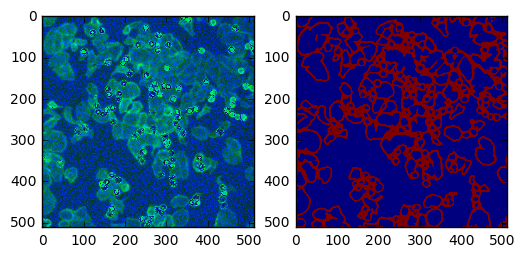

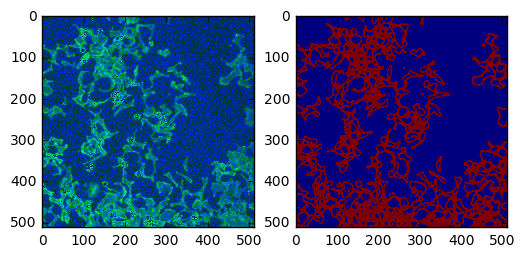

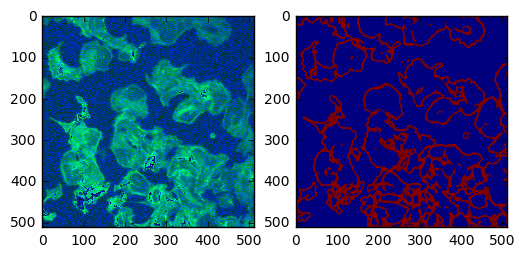

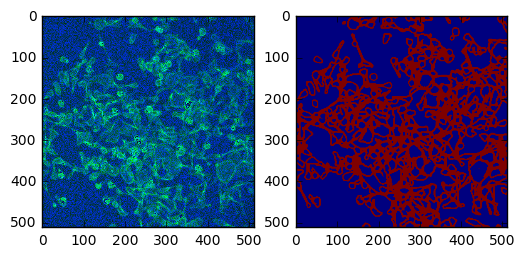

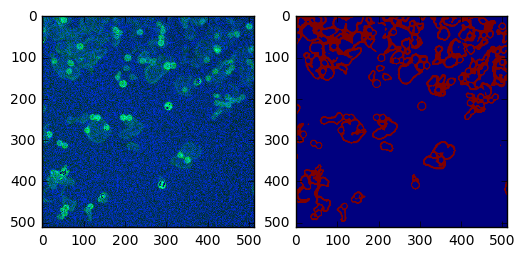

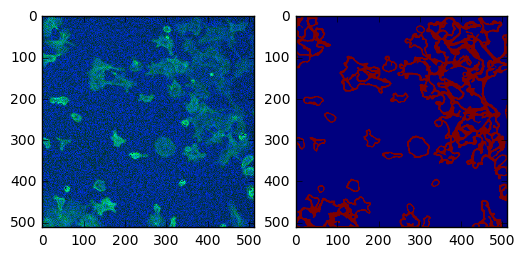

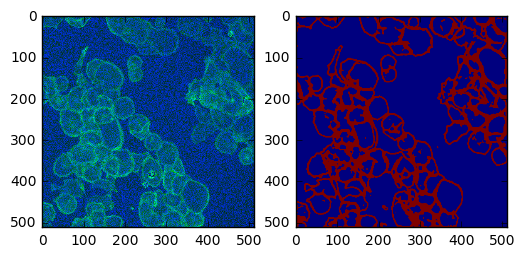

In [ ]:
for k, img in data_test.items():
    seg = get_segmentation(img[np.newaxis, :])[0]
    f, (ax1, ax2) = plt.subplots(1, 2)
    ax1.imshow(((img.transpose(1, 2, 0) + 0.5) * 255).astype(np.uint8))
    plt.imshow(seg)